# Point Source Deconvolution

Deconvolution of a small, simulated point-source image demonstrating the simplest possible example.  This is an idealized version of deconvolving subresolution bead images.

**NOTE**: This is definitely a CPU-friendly example (it is not computationally intensive at all).

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from flowdec import psf as fd_psf
from flowdec import data as fd_data
from flowdec import restoration as fd_restoration
from scipy.signal import fftconvolve

First, create a small odd length image volume so that the center can be a single voxel:

In [4]:
img = np.zeros((11, 11, 11), dtype='float32') # z, y, x
img[5, 5, 5] = 1
img.shape, img.dtype

((11, 11, 11), dtype('float32'))

Create a theoretical PSF to be used to simulate blurring of this image:

In [5]:
# This is meant to be representative of a 60x widefield image capture (all distance units are in microns)
psf = fd_psf.GibsonLanni(
    na=1.4,           # Numerical aperture
    m=60,             # Magnification
    ni0=1.51,         # Immersion RI
    res_lateral=.125, # X/Y resolution
    res_axial=.3,     # Axial resolution
    wavelength=.580,  # Emission wavelength 
    size_x=img.shape[2], 
    size_y=img.shape[1], 
    size_z=img.shape[0]
).generate()
psf.shape, psf.dtype

((11, 11, 11), dtype('float64'))

Convolve the simulated point source with the PSF, noting that in this case the "blurred" result
and the original will be identical up to a constant factor (but this step is left in to make 
it easier to try other simulated images with more than a single voxel):

In [11]:
# Use scipy.ndimage.convolve (which is a lot slower) if fftconvolve moves non-centered pixels to different quandrants
# (the function uses circulant convolutions that sometimes move single pixels at quadrant corners into other quadrants)
blur = fftconvolve(img, psf/psf.sum(), mode='same')
blur.shape, blur.dtype

((11, 11, 11), dtype('float64'))

Run deconvolution and record similarity metrics between the current result and original image at each iteration:

In [12]:
from skimage.measure import compare_mse, compare_psnr, compare_ssim

scores = {}
def observer_fn(img_restore, i, *args):
    scores[i] = {
        'mse': compare_mse(img, img_restore),
        'ssim': compare_ssim(img, img_restore),
        'psnr': compare_psnr(img, img_restore)
    }
    
algo = fd_restoration.RichardsonLucyDeconvolver(3, observer_fn=observer_fn).initialize()
res = algo.run(fd_data.Acquisition(blur, psf), niter=500).data

Plot the scores vs iteration number, noting that most converge at or before 100 iterations:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11a96c518>,
      dtype=object)

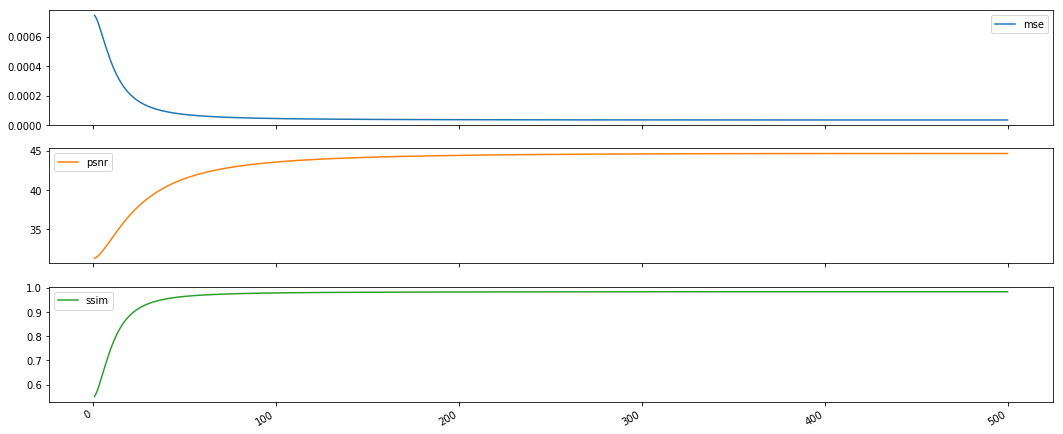

In [8]:
pd.DataFrame(scores).T.plot(subplots=True, figsize=(18, 8))

In [9]:
pd.DataFrame(scores).T.tail()

,mse,psnr,ssim
496,0.000034,44.648076,0.983180
497,0.000034,44.648021,0.983180
498,0.000034,44.647962,0.983180
499,0.000034,44.647898,0.983179
500,0.000034,44.647841,0.983179


Show all of the images used as max-z projections with annotated pixel values:

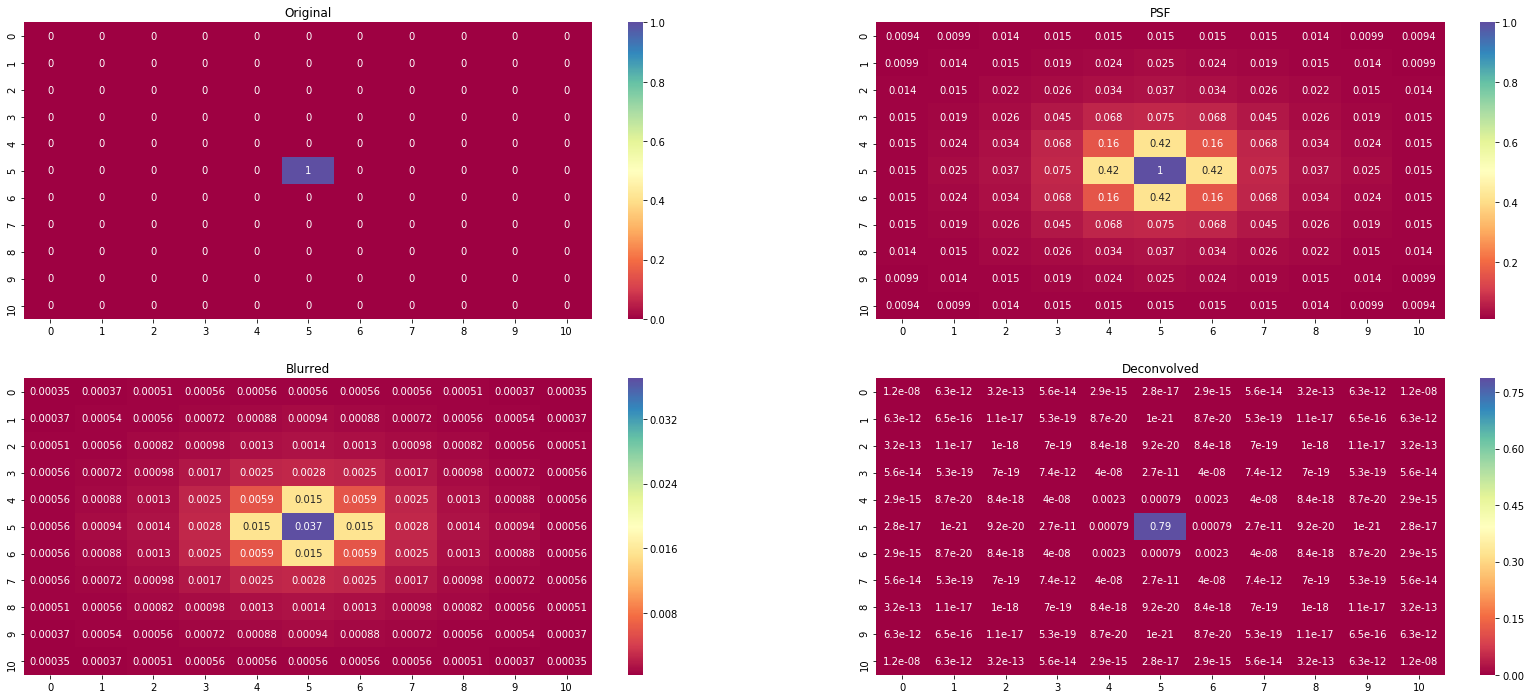

In [10]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(28, 12)
sns.heatmap(img.max(0), cmap='Spectral', annot=True, ax=axs[0, 0])
axs[0, 0].set_title('Original')
sns.heatmap(psf.max(0), cmap='Spectral', annot=True, ax=axs[0, 1])
axs[0, 1].set_title('PSF')
sns.heatmap(blur.max(0), cmap='Spectral', annot=True, ax=axs[1, 0])
axs[1, 0].set_title('Blurred')
sns.heatmap(res.max(0), cmap='Spectral', annot=True, ax=axs[1, 1])
axs[1, 1].set_title('Deconvolved')
None